# Putting the pieces of kicker data together 
#### Matthew Johnson, August 13, 2018

$KickerPts = 1 *(Made PAT) + 3*(FG_{d\leq 39}) + 4*(FG_{d\in [40,49]}) + 5*(FG_{d\geq 50}) - 1*(Missed FG)$
<br>

- Calculate predictions for data, data + vegas, data + weather, all 3

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.pipeline import Pipeline, make_pipeline
warnings.filterwarnings('ignore')

kickers09to17 = pd.read_csv('kicker_data_09_17.csv')
weather09to13 = pd.read_csv('weather_data09to13.csv') 
vegas09to17 = pd.read_csv('vegas_odds09to17.csv') # Weeks 6-16

dfs = [kickers09to17, weather09to13, vegas09to17]
dfs[1].drop('Unnamed: 0', axis=1, inplace=True)
dfs[2].drop('Unnamed: 0', axis=1, inplace=True)

In [2]:
mergecodes = []
mergecodes2 = []

for df in dfs:
    print (df.shape)
    mergecodes.append(list(df['mergeCode'].unique()))
    mergecodes2.append(list(df['mergeCode2'].unique()))

(2642, 65)
(2058, 16)
(2878, 10)


In [3]:
# A - kicker data
# B - weather
# C - vegas odds

A = set(mergecodes[0])
B = set(mergecodes[1])
sd = A.symmetric_difference(B)
intersect1 = A.intersection(B)
print('A:', len(A), 'B:', len(B), 'sym_diff:', len(sd), 'intersect:', len(intersect1))

A = set(mergecodes[0])
C = set(mergecodes[2])
sd = A.symmetric_difference(C)
intersect2 = A.intersection(C)
print('A:', len(A), 'C:', len(C), 'sym_diff:', len(sd), 'intersect:', len(intersect2))

C = set(mergecodes[2])
B = set(mergecodes[1])
sd = C.symmetric_difference(B)
intersect3 = C.intersection(B)
print('C:', len(C), 'B:', len(B), 'sym_diff:', len(sd), 'intersect:', len(intersect3))

intersect_all = intersect1.intersection(C)
print('int_all:', len(intersect_all))

A: 2642 B: 2058 sym_diff: 2160 intersect: 1270
A: 2642 C: 2873 sym_diff: 1013 intersect: 2251
C: 2873 B: 2058 sym_diff: 2223 intersect: 1354
int_all: 1199


In [4]:
# A - kicker data
# B - weather
# C - vegas odds

A = set(mergecodes2[0])
B = set(mergecodes2[1])
sd = A.symmetric_difference(B)
intersect1 = A.intersection(B)
print('A:', len(A), 'B:', len(B), 'sym_diff:', len(sd), 'intersect:', len(intersect1))

A = set(mergecodes2[0])
C = set(mergecodes2[2])
sd = A.symmetric_difference(C)
intersect2 = A.intersection(C)
print('A:', len(A), 'C:', len(C), 'sym_diff:', len(sd), 'intersect:', len(intersect2))

C = set(mergecodes2[2])
B = set(mergecodes2[1])
sd = C.symmetric_difference(B)
intersect3 = C.intersection(B)
print('C:', len(C), 'B:', len(B), 'sym_diff:', len(sd), 'intersect:', len(intersect3))

intersect_all = intersect1.intersection(C)
print('int_all:', len(intersect_all))

A: 2640 B: 2052 sym_diff: 2032 intersect: 1330
A: 2640 C: 2872 sym_diff: 898 intersect: 2307
C: 2872 B: 2052 sym_diff: 2422 intersect: 1251
int_all: 1214


In [5]:
df1 = pd.merge(dfs[0], dfs[1], on='mergeCode2', how='inner')
df2 = pd.merge(df1, dfs[2], on='mergeCode2', how='inner')
print(df2.shape)

(1232, 89)


In [6]:
offenseVariables = ['3rdDown_rate', 'Drive', 'FirstDown','Kicker_Pts',
    'TwoPointConv','Drive_rolling5', 'Kicker_Pts_rolling5', 
    'PointsScored_rolling5', 'Yards.Gained_rolling5', 'FG_range_per_drive', 'RZ_per_drive',
    'punts_per_drive', 'Completion_pct', 'TwoPoint_conv_rate']

defenseVariables = ['DEF_3rdDownSuccess_rolling5', 'DEF_Drive_rolling5', 'DEF_FirstDown_rolling5', 
    'DEF_Kicker_Pts_rolling5',  'DEF_Touchdown_rolling5', 
    'DEF_Yards.Gained_rolling5','DEF_FG_range_per_drive', 'DEF_RZ_per_drive', 'DEF_PointsScored_rolling5',
    'DEF_punts_per_drive', 'DEF_Completion_pct']

generalVariables = ['offenseTeam.1', 'defenseTeam_x', 'Season_x', 'Week_y', 'date_x', 
        'off_score', 'def_score', 'temperature', 'wind_chill', 'humidity', 'wind_mph', 
        'home_team', 'Year', 
        'Relative_Line', 'Total', 'Exp_Pts', 'mergeCode', 'mergeCode2', 'mergeCode_x']

df_off = df2[offenseVariables]
df_def = df2[defenseVariables]
df_gen = df2[generalVariables]

df_gen.columns = ['offenseTeam', 'defenseTeam', 'Season', 'Week', 'date',
       'off_score', 'def_score', 'temperature', 'wind_chill', 'humidity',
       'wind_mph', 'home_team', 'Year', 'Relative_Line', 'Total', 'Exp_Pts', 
       'mergeCode', 'mergeCode2', 'mergeCode_x']

data = pd.concat([df_gen, df_off, df_def], axis=1)
kicker_pts = df2['Kicker_Pts']

In [7]:
outliers = data[ (data['Kicker_Pts'] <= 1) | (data['Kicker_Pts'] >= 25)]
outliers.shape

#data_drop_outliers = data[ (data['Kicker_Pts'] >= 1) | (data['Kicker_Pts'] <= 25)]

(65, 44)

In [8]:
data2 = data.drop(['off_score', 'def_score'], axis=1)
data2['Season'] = data2['Season'].astype('category')
data2['Week'] = data2['Week'].astype('category')
data2['Year'] = data2['Year'].astype('category')

num_data = data2.select_dtypes(include=['int64', 'float64'])

In [11]:

sns.distplot(kicker_pts, bins=20, fit=norm,
            kde_kws={"color": "k", "lw": 3, "label": "KDE"},
            hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "g"});

ImportError: cannot import name 'norm'

In [106]:
corr_rank

Kicker_Pts                     1.000
DEF_Kicker_Pts_rolling5        0.470
Kicker_Pts_rolling5            0.454
off_score                      0.341
DEF_PointsScored_rolling5      0.234
PointsScored_rolling5          0.173
DEF_Yards.Gained_rolling5      0.135
DEF_Touchdown_rolling5         0.107
Yards.Gained_rolling5          0.099
DEF_Drive_rolling5             0.091
Season                         0.072
Drive                          0.072
DEF_FirstDown_rolling5         0.067
FirstDown                      0.067
Year                           0.066
Total                          0.037
temperature                    0.031
DEF_3rdDownSuccess_rolling5    0.018
Exp_Pts                        0.010
3rdDown_rate                  -0.001
Relative_Line                 -0.013
Drive_rolling5                -0.014
DEF_RZ_per_drive              -0.027
wind_chill                    -0.032
RZ_per_drive                  -0.037
wind_mph                      -0.049
humidity                      -0.050
W

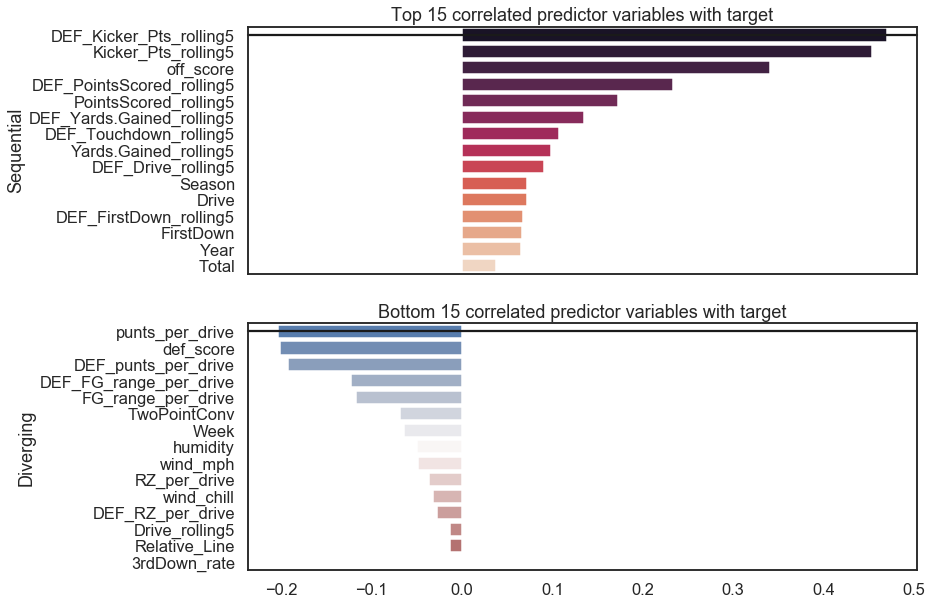

In [112]:
sns.set(style="white", context="talk")

corr = data.corr()['Kicker_Pts'].sort_values(ascending=False)

corr_rank_high = corr_rank[1:16]
corr_rank_low = corr_rank[-18:-3].sort_values(ascending=True)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

sns.barplot(y=corr_rank_high.index, x=corr_rank_high.values, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Sequential")
ax1.set_title('Top 15 correlated predictor variables with target')

sns.barplot(y=corr_rank_low.index, x=corr_rank_low.values, palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Diverging")
ax2.set_title('Bottom 15 correlated predictor variables with target');

### Modelling

In [12]:
from sklearn.linear_model import ElasticNet, Lasso, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [17]:
rolling_kpts = num_data['Kicker_Pts_rolling5'].copy()
rolling_kpts.columns = ['Kicker_Pts_rolling5b']
def_rolling_kpts = num_data['DEF_Kicker_Pts_rolling5'].copy()
def_rolling_kpts.columns = ['DEF_Kicker_Pts_rolling5b']

In [20]:
from scipy.stats import norm, skew

all_data = num_data.drop(['Kicker_Pts', 'Relative_Line', 'TwoPoint_conv_rate'], axis=1)

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()


Skew in numerical features: 



,Skew
TwoPointConv,5.544
3rdDown_rate,4.762
DEF_3rdDownSuccess_rolling5,3.305
wind_mph,1.306
DEF_FirstDown_rolling5,0.344


In [21]:
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
#skewed_features = skewed_features.drop(['Relative_Line', 'TwoPoint_conv_rate'])
print("There are {} skewed numerical features to Box Cox transform".format(len(skewed_features)))

lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data = pd.concat([all_data, num_data['Relative_Line']], axis=1)

There are 29 skewed numerical features to Box Cox transform


In [22]:
all_data['3rdDown_rate'].fillna(all_data['3rdDown_rate'].mean(), inplace=True)
all_data['wind_chill'].fillna(all_data['temperature'], inplace=True)



In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = pd.concat([all_data, rolling_kpts, num_data['Relative_Line']], axis=1)
y = kicker_pts

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

rf2 = RandomForestRegressor(n_estimators = 1000, random_state = 2018)
rf2.fit(Xtrain, ytrain);

In [28]:
predictions2 = rf2.predict(Xtest)
errors = abs(predictions2 - ytest)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 3.02


In [256]:
predictions2 = rf2.predict(Xtest)
errors = abs(predictions2 - ytest)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 2.84


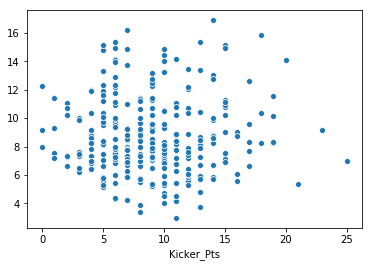

In [257]:
sns.scatterplot(x=ytest, y=predictions);

In [60]:
rf_df = pd.DataFrame({'feature': pd.Series(X.columns),'importance': rf2.feature_importances_})
rf_df.sort_values(by='importance', ascending=False)[0:10]

,feature,importance
21,DEF_Kicker_Pts_rolling5,0.150
11,Kicker_Pts_rolling5,0.114
29,Kicker_Pts_rolling5,0.099
8,FirstDown,0.041
23,DEF_Yards.Gained_rolling5,0.039
16,punts_per_drive,0.038
13,Yards.Gained_rolling5,0.037
25,DEF_RZ_per_drive,0.033
12,PointsScored_rolling5,0.032
0,temperature,0.032


In [42]:
pred_df = pd.DataFrame({'Actual': ytest, 'Pred': predictions2, 'Rolling':Xtest['Kicker_Pts_rolling5'].iloc[:,1]})

pred_df['residual'] = abs(pred_df['Actual'] - pred_df['Pred'])
pred_df['roll_res'] = abs(pred_df['Actual'] - pred_df['Rolling'])


In [44]:
pred_df.describe()

,Actual,Pred,Rolling,residual,roll_res
count,308.000,308.000,308.000,308.000,308.000
mean,8.828,8.945,8.750,3.025,3.422
std,4.787,2.697,2.131,2.469,2.657
min,0.000,3.540,3.000,0.025,0.000
25%,5.000,6.837,7.000,1.003,1.000
50%,8.000,8.747,9.000,2.502,3.000
75%,12.000,10.750,10.000,4.354,5.000
max,28.000,15.183,15.000,15.441,18.000


In [161]:
pred_df = pd.DataFrame({'Actual': ytest, 'Pred': predictions})

In [166]:
pred_df['residual'] = abs(pred_df['Actual'] - pred_df['Pred'])

good_guess = pred_df[ pred_df['residual'] <= 2.0 ]
good_guess.sort_values(by='residual').head()

,Actual,Pred,residual
498,8,7.975,0.025
869,7,6.965,0.035
278,9,9.048,0.048
233,9,9.088,0.088
1224,8,7.896,0.104


In [168]:
poor_guess = pred_df[ pred_df['residual'] >= 7.0 ]
poor_guess.sort_values(by='residual', ascending=False).head()

,Actual,Pred,residual
596,23,10.702,12.298
984,18,7.133,10.867
719,18,7.186,10.814
539,18,7.853,10.147
1076,22,13.300,8.700


In [169]:
pred_df.describe()

,Actual,Pred,residual
count,308.000,308.000,308.000
mean,8.919,8.693,2.985
std,4.474,2.662,2.246
min,-1.000,2.970,0.025
25%,6.000,6.952,1.158
50%,9.000,8.165,2.600
75%,12.000,10.236,4.296
max,23.000,16.889,12.298


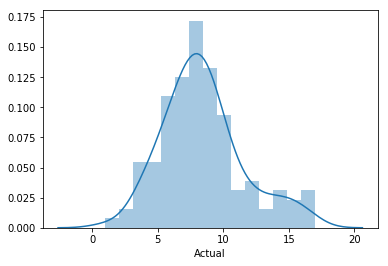

In [176]:
sns.distplot(good_guess['Actual'], bins=15)

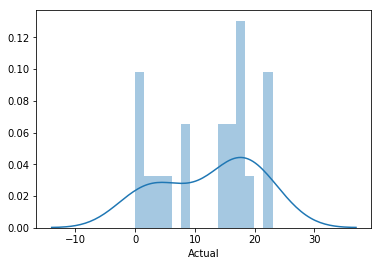

In [175]:
sns.distplot(poor_guess['Actual'], bins=15)

In [64]:
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from bayes_opt import BayesianOptimization
from tqdm import tqdm
__author__ = "Vladimir Iglovikov"

def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha,
                lambd,
                n_est):

    params['min_child_weight'] = int(min_child_weight)
    params['cosample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)
    params['lambda'] = max(lambd, 0)
    params['n_estimators'] = max(n_est,1)

    cv_result = xgb.cv(params, xgtrain, num_boost_round=num_rounds, nfold=5,
             seed=random_state,
             callbacks=[xgb.callback.early_stop(50)])

    return -cv_result['test-mae-mean'].values[-1]


def prepare_data():
    #train = pd.read_csv('/Users/mattjohnson/Desktop/Python 2018/kaggleHousing/train.csv')
    #categorical_columns = train.select_dtypes(include=['object']).columns
    
    X = pd.concat([all_data, num_data['Relative_Line']], axis=1)
    y = kicker_pts
    
    xgtrain = xgb.DMatrix(X, label=y)

    return xgtrain


if __name__ == '__main__':
    xgtrain = prepare_data()

    num_rounds = 3000
    random_state = 2018
    num_iter = 25
    init_points = 5
    params = {
        'silent': 1,
        'eval_metric': 'mae', #
        'verbose_eval': True,
        'seed': random_state
    }

    xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                                'colsample_bytree': (0.1, 1),
                                                'max_depth':(1,10),
                                                'subsample': (0.5, 1),
                                                'gamma': (0, 10),
                                                'alpha': (0, 10),
                                                'lambd': (0, 1),
                                                'n_est': (2000,3500)
                                                })

    xgbBO.maximize(init_points=init_points, n_iter=num_iter)


Initialization
---------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |     lambd |   max_depth |   min_child_weight |     n_est |   subsample | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 50 rounds.
Stopping. Best iteration:
[7]	train-mae:2.67922+0.0333031	test-mae:3.14649+0.0714518

    1 | 00m00s |   -3.14649 |    9.6322 |             0.4509 |    8.3199 |    0.0012 |      8.4415 |            17.7496 | 2577.9747 |      0.5000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 50 rounds.
Stopping. Best iteration:
[9]	train-mae:2.72809+0.0199729	test-mae:3.0314+0.0783003

    2 | 00m00s |   -3.03140 |    9.0504 |             0.1374 |    2.5381 |    0.3320 |

Will train until test-mae hasn't improved in 50 rounds.
Stopping. Best iteration:
[18]	train-mae:2.95818+0.022327	test-mae:3.036+0.0556481

   20 | 00m18s |   -3.03600 |    0.0000 |             1.0000 |    0.0000 |    1.0000 |      1.0000 |             1.0000 | 2505.3619 |      0.5000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 50 rounds.
Stopping. Best iteration:
[36]	train-mae:2.91127+0.0198289	test-mae:2.99281+0.0573829

   21 | 00m23s |   -2.99281 |   10.0000 |             0.1000 |    0.0000 |    0.0000 |      1.0000 |            20.0000 | 3160.9166 |      1.0000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 50 rounds.
Stopping. Best iteration:
[23]	train-mae:2.94127+0.0247076	test-mae:3.02903+0.0631517

   22 | 00m19s |   -3.02903 |   10.0000 |             0.1000 |   10.0000 |    0.0000 |      1.0000 |      

In [65]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.1000, gamma=0.000, 
                             learning_rate=0.05, max_depth=1, 
                             min_child_weight=20.000, n_estimators=3338,
                             reg_alpha=10.000, reg_lambda=0,
                             subsample=1.000, silent=1,
                             random_state =2018, nthread = -1)

In [79]:
X = pd.concat([all_data, num_data['Relative_Line']], axis=1)
y = kicker_pts

In [80]:
model_xgb.fit(X, y)

scores_xgb = cross_val_score(model_xgb, X, y, cv=10)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_xgb.mean(), scores_xgb.std() * 2))

Accuracy: 0.2851 (+/- 0.1233)


In [88]:
X2 = pd.concat([X,y], axis=1)
#X2 = X2[['Kicker_Pts_rolling5', 'Kicker_Pts']]
X2['dev_from_mean'] = X2['Kicker_Pts_rolling5']-X2['Kicker_Pts']
X2['abs'] = abs(X2['dev_from_mean'])

In [95]:
X2.corr()['dev_from_mean'].sort_values(ascending=False)

dev_from_mean                  1.000
DEF_punts_per_drive            0.192
punts_per_drive                0.178
DEF_FG_range_per_drive         0.122
FG_range_per_drive             0.104
wind_chill                     0.061
humidity                       0.061
TwoPointConv                   0.060
wind_mph                       0.045
RZ_per_drive                   0.032
DEF_RZ_per_drive               0.032
Drive_rolling5                 0.014
temperature                    0.005
3rdDown_rate                  -0.005
Relative_Line                 -0.005
DEF_3rdDownSuccess_rolling5   -0.016
Exp_Pts                       -0.020
Total                         -0.030
FirstDown                     -0.063
DEF_FirstDown_rolling5        -0.065
Drive                         -0.070
Yards.Gained_rolling5         -0.084
DEF_Drive_rolling5            -0.086
DEF_Touchdown_rolling5        -0.109
DEF_Yards.Gained_rolling5     -0.138
PointsScored_rolling5         -0.161
DEF_PointsScored_rolling5     -0.236
K

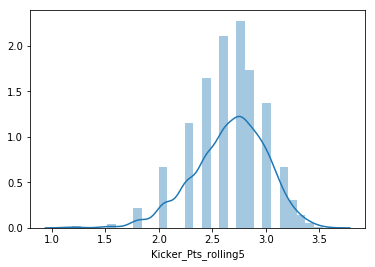

In [96]:
sns.distplot(X2['Kicker_Pts_rolling5'])

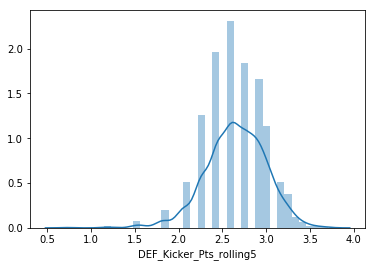

In [97]:
sns.distplot(X2['DEF_Kicker_Pts_rolling5'])